In [1]:
from os.path import join
import sys
import numpy as np

def load_data(load_dir, bid):
    SIZE = 512
    u = np.zeros((SIZE + 2, SIZE + 2))
    u[1:-1, 1:-1] = np.load(join(load_dir, f"{bid}_domain.npy"))
    interior_mask = np.load(join(load_dir, f"{bid}_interior.npy"))
    return u, interior_mask


def jacobi(u, interior_mask, max_iter, atol=1e-6):
    u = np.copy(u)

    for i in range(max_iter):
        # Compute average of left, right, up and down neighbors, see eq. (1)
        u_new = 0.25 * (u[1:-1, :-2] + u[1:-1, 2:] + u[:-2, 1:-1] + u[2:, 1:-1])
        u_new_interior = u_new[interior_mask]
        delta = np.abs(u[1:-1, 1:-1][interior_mask] - u_new_interior).max()
        u[1:-1, 1:-1][interior_mask] = u_new_interior

        if delta < atol:
            break
    return u


def summary_stats(u, interior_mask):
    u_interior = u[1:-1, 1:-1][interior_mask]
    mean_temp = u_interior.mean()
    std_temp = u_interior.std()
    pct_above_18 = np.sum(u_interior > 18) / u_interior.size * 100
    pct_below_15 = np.sum(u_interior < 15) / u_interior.size * 100
    return {
        'mean_temp': mean_temp,
        'std_temp': std_temp,
        'pct_above_18': pct_above_18,
        'pct_below_15': pct_below_15,
    }


In [3]:
# Load data
LOAD_DIR = '/dtu/projects/02613_2025/data/modified_swiss_dwellings/'
with open(join(LOAD_DIR, 'building_ids.txt'), 'r') as f:
    building_ids = f.read().splitlines()

N = 10
building_ids = building_ids[:N]

# Load floor plans
all_u0 = np.empty((N, 514, 514))
all_interior_mask = np.empty((N, 512, 512), dtype='bool')
for i, bid in enumerate(building_ids):
    u0, interior_mask = load_data(LOAD_DIR, bid)
    all_u0[i] = u0
    all_interior_mask[i] = interior_mask

# Run jacobi iterations for each floor plan
MAX_ITER = 20_000
ABS_TOL = 1e-4

all_u = np.empty_like(all_u0)
for i, (u0, interior_mask) in enumerate(zip(all_u0, all_interior_mask)):
    u = jacobi(u0, interior_mask, MAX_ITER, ABS_TOL)
    all_u[i] = u

# Print summary statistics in CSV format
stat_keys = ['mean_temp', 'std_temp', 'pct_above_18', 'pct_below_15']
print('building_id, ' + ', '.join(stat_keys))  # CSV header
for bid, u, interior_mask in zip(building_ids, all_u, all_interior_mask):
    stats = summary_stats(u, interior_mask)
    print(f"{bid},", ", ".join(str(stats[k]) for k in stat_keys))

building_id, mean_temp, std_temp, pct_above_18, pct_below_15
10000, 14.01233878811275, 6.367431059312565, 30.941014791508444, 55.542295034537624
10009, 11.000135812436373, 5.811144379826625, 16.6712734948236, 74.9723590310584
10014, 14.744169941950119, 7.037733284673848, 38.26367541377415, 52.80837116508215
10019, 14.735524480624482, 7.030325006703675, 38.14915412864569, 52.92926826787113
10029, 10.616037322820358, 6.317331938274926, 18.25563221896085, 74.51301795448481
10031, 12.507072852890545, 6.278432089100354, 24.044722033998173, 66.39513301711693
10051, 13.289039951277402, 5.999085063388632, 25.97693550756574, 62.859923608050536
10053, 11.366493551285709, 6.26121798185875, 19.9510754583921, 72.41052538787024
10056, 14.220114507861702, 6.179461157398302, 31.763454814173965, 57.06174975667784
10064, 12.71696893739585, 6.964227784263683, 28.79137124461432, 62.75688345539249


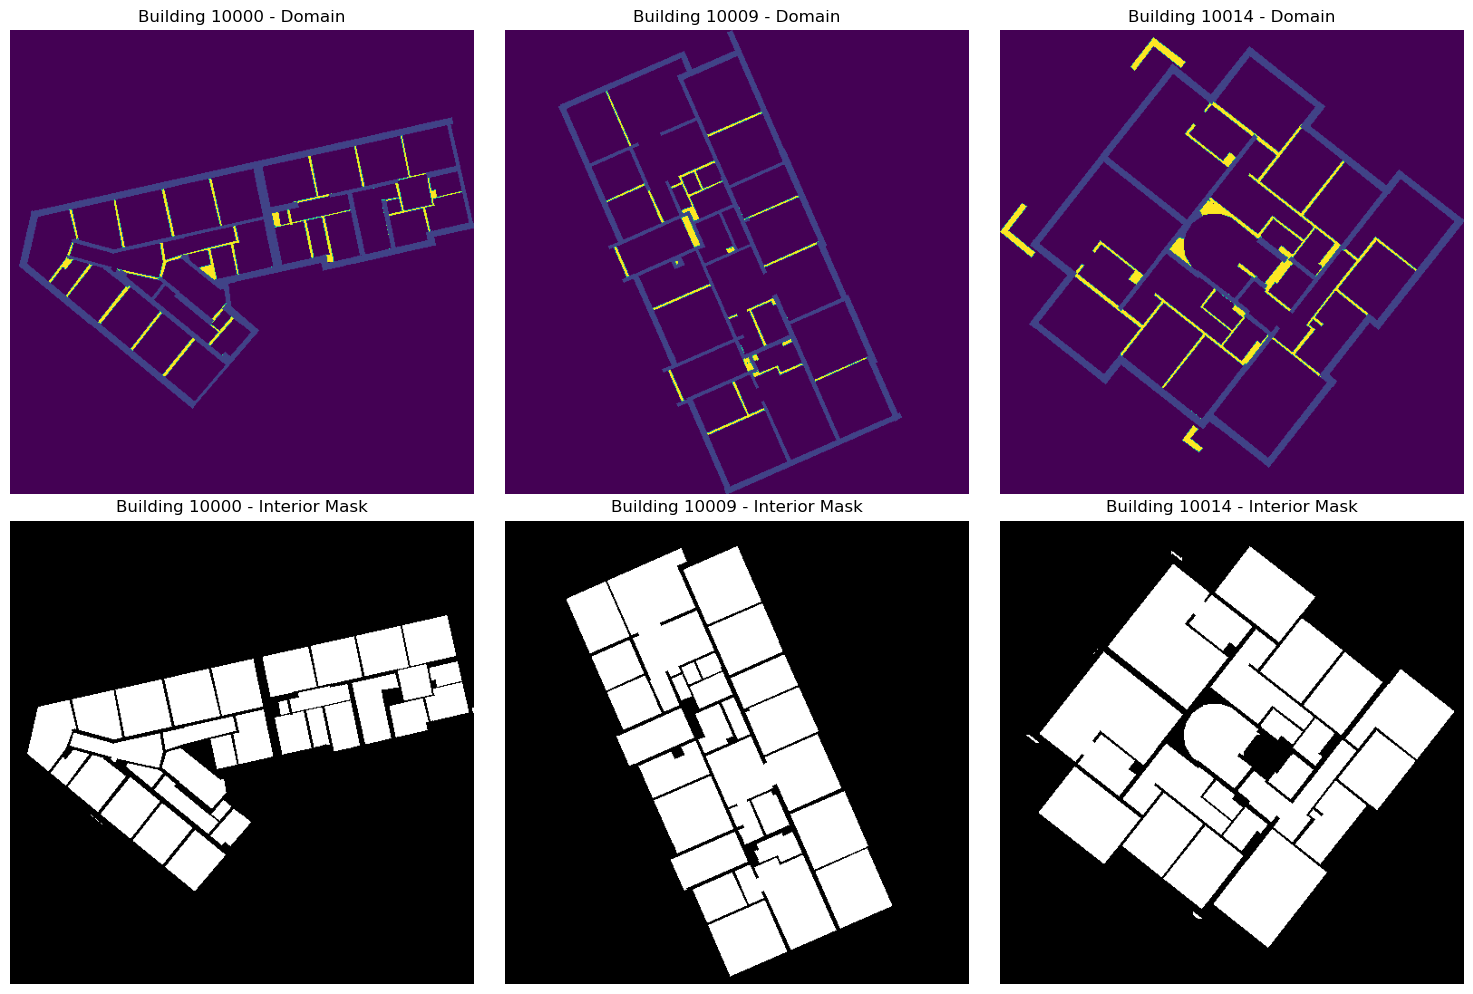

In [5]:
import matplotlib.pyplot as plt

# Function to visualize the domain and interior mask
def visualize_floorplans(building_ids, load_dir, num_plans=3):
    fig, axes = plt.subplots(2, num_plans, figsize=(5 * num_plans, 10))
    for i, bid in enumerate(building_ids[:num_plans]):
        # Load domain and interior mask
        domain = np.load(join(load_dir, f"{bid}_domain.npy"))
        interior = np.load(join(load_dir, f"{bid}_interior.npy"))
        
        # Plot domain
        axes[0, i].imshow(domain, cmap='viridis')
        axes[0, i].set_title(f"Building {bid} - Domain")
        axes[0, i].axis('off')
        
        # Plot interior mask
        axes[1, i].imshow(interior, cmap='gray')
        axes[1, i].set_title(f"Building {bid} - Interior Mask")
        axes[1, i].axis('off')
    
    plt.tight_layout()
    plt.show()

# Visualize the first few floorplans
visualize_floorplans(building_ids, LOAD_DIR, num_plans=3)